In [2]:
import pandas as pd
import pickle
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, silhouette_score, v_measure_score
import json
import numpy
import nltk
import os
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('punkt')

In [2]:
class GMM:
    def __init__(self, n_components, max_iter=100, comp_names=None):

        self.n_componets = n_components
        self.max_iter = max_iter
        if comp_names == None:
            self.comp_names = [index for index in range(self.n_componets)]
        else:
            self.comp_names = comp_names
        self.pi = [1/self.n_componets for comp in range(self.n_componets)]

    def multivariate_normal(self, X, mean_vector, covariance_matrix):
        return (2*np.pi)**(-len(X)/2)*np.linalg.det(covariance_matrix)**(-1/2)*np.exp(-np.dot(np.dot((X-mean_vector).T, np.linalg.inv(covariance_matrix)), (X-mean_vector))/2)

    def fit(self, X):
        new_X = np.array_split(X, self.n_componets)
        self.mean_vector = [np.mean(x, axis=0) for x in new_X]
        self.covariance_matrixes = [np.cov(x.T) for x in new_X]
        eps = 1e-6
        delta_llh = 0
        llh = 1000
        del new_X
        sump = 0
        for iteration in range(self.max_iter):
            if llh < eps:
                break
            ''' --------------------------   E - STEP   -------------------------- '''
            self.r = np.zeros((len(X), self.n_componets))
            for n in range(len(X)):
                for k in range(self.n_componets):
                    self.r[n][k] = self.pi[k] * self.multivariate_normal(X[n], self.mean_vector[k], self.covariance_matrixes[k])
                    self.r[n][k] /= sum([self.pi[j]*self.multivariate_normal(X[n], self.mean_vector[j], self.covariance_matrixes[j]) for j in range(self.n_componets)])
                    sump += self.r[n][k]
                delta_llh = np.log(sump)
                llh += delta_llh
            N = np.sum(self.r, axis=0)
            ''' --------------------------   M - STEP   -------------------------- '''
            self.mean_vector = np.zeros((self.n_componets, len(X[0])))
            for k in range(self.n_componets):
                for n in range(len(X)):
                    self.mean_vector[k] += self.r[n][k] * X[n]
            self.mean_vector = [1/N[k]*self.mean_vector[k] for k in range(self.n_componets)]
            self.covariance_matrixes = [np.zeros((len(X[0]), len(X[0]))) for k in range(self.n_componets)]
            for k in range(self.n_componets):
                self.covariance_matrixes[k] = np.cov(X.T, aweights=(self.r[:, k]), ddof=0)
            self.covariance_matrixes = [1/N[k]*self.covariance_matrixes[k] for k in range(self.n_componets)]
            self.pi = [N[k]/len(X) for k in range(self.n_componets)]
    def predict(self, X):
        probas = []
        for n in range(len(X)):
            probas.append([self.multivariate_normal(X[n], self.mean_vector[k], self.covariance_matrixes[k])
                           for k in range(self.n_componets)])
        cluster = []
        for proba in probas:
            cluster.append(self.comp_names[proba.index(max(proba))])
        return cluster

In [2]:
header_list = ['id', 'news_id', 'category', 'subcategory', 'abstract', 'url', 'title_entities', 'abstract_entities']
for filename in ['news_test.tsv', 'news_train.tsv', 'news_valid.tsv']:
    file_df = pd.read_csv('news/news_abstract/'+filename, sep='\t', names=header_list)
    if filename == 'news_test.tsv':
        df = file_df.copy()
    else:
        df = pd.concat([df, file_df])

In [3]:
# Opening JSON file
with open('news/news_bodies/news_test.json') as json_file:
    body_test = json.load(json_file)

In [4]:
# Opening JSON file
with open('news/news_bodies/news_train.json') as json_file:
    body_train = json.load(json_file)

In [5]:
# Opening JSON file
with open('news/news_bodies/news_valid.json') as json_file:
    body_valid = json.load(json_file)

In [6]:
# Opening JSON file
with open('news/news_data/data_test.json') as json_file:
    data_test = json.load(json_file)

In [7]:
# Opening JSON file
with open('news/news_data/data_train.json') as json_file:
    data_train = json.load(json_file)

In [8]:
# Opening JSON file
with open('news/news_data/data_valid.json') as json_file:
    data_valid = json.load(json_file)

In [9]:
body_df = pd.concat([pd.DataFrame(body_test), pd.DataFrame(body_train), pd.DataFrame(body_valid)])

In [10]:
def extract_body(lst):
    return str(''.join(lst))

In [11]:
body_df['body'] = body_df['body'].apply(extract_body)

In [12]:
data_df = pd.concat([pd.DataFrame(data_train), pd.DataFrame(data_train), pd.DataFrame(data_valid)])

In [13]:
df = df.drop_duplicates()
body_df = body_df.drop_duplicates()
data_df = data_df.drop_duplicates()

In [14]:
def extract_nid(val):
    return val[-14:-5]

In [15]:
df['url'] = df['url'].astype(str)
df['nid'] = df['url'].apply(extract_nid)
df['nid'] = df['nid'].apply(lambda s: s.replace('d/', ''))

In [16]:
df = df.merge(body_df, left_on='nid', right_on='nid')

In [17]:
df = df.merge(data_df, left_on='nid', right_on='nid')

In [18]:
df = df.drop(['title_entities', 'abstract_entities', 'url', 'nid'], axis=1)

In [19]:
clear_df = df.copy()

In [21]:
pd.set_option('display.max_colwidth', None)

In [22]:
df['body'] = df['body'] + df['abstract'] + df['subcategory']

In [23]:
import re
from nltk.corpus import stopwords

# Оставляем только кириллические символы
regex = re.compile(u"[A-Za-z]+")

def words_only(text, regex=regex):
    return " ".join(regex.findall(str(text)))

In [24]:
df.body = df.body.str.lower()
df.loc[:, 'body'] = df.body.apply(words_only)

In [25]:
# Удаляем стоп-слова
mystopwords = stopwords.words('english') + ['-', '-']

def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return u" ".join([token for token in text.split() if not token in mystopwords])
    except:
        return u""
    
df.body = df.body.apply(remove_stopwords)   

In [26]:
%%time 
from pymystem3 import Mystem
from nltk.stem import WordNetLemmatizer


# нормализуем текст
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(text, lemmatizer=wordnet_lemmatizer):
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

df.body = df.body.apply(lemmatize)

Wall time: 3min 50s


In [27]:
vect = TfidfVectorizer()
texts = df.body.values

In [28]:
X_txts = vect.fit_transform(texts)

In [218]:
import time
time_arr = []
def exec_time(start, end):
    diff_time = end - start
    m, s = divmod(diff_time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
    time_arr.append([h, m, s])
    print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

In [219]:
start = time.time()
truncatedSVD = TruncatedSVD(n_components=100)
truncated_X_txts = truncatedSVD.fit_transform(X_txts)
end = time.time()
exec_time(start,end)

Execution Time: 00:00:57


In [221]:
gm = GaussianMixture(n_components=380)
gm.fit(truncated_X_txts)
predictions = gm.predict(truncated_X_txts)

In [222]:
means = gm.means_

In [225]:
silhouette_score(truncated_X_txts, predictions)

0.0688529029943913

# Testing

In [63]:
texts = df.body.values
truncatedSVD = TruncatedSVD()
gm = GaussianMixture(n_components=2)
result = []
for max_df in [0.25, 0.30, 0.35]:
    for ngram_range in [(1, 1), (1, 2)]:
        start = time.time()
        vect = TfidfVectorizer(max_df=max_df, ngram_range=ngram_range)
        X_txts = vect.fit_transform(texts)
        truncated_X_txts = truncatedSVD.fit_transform(X_txts)
        gm.fit(truncated_X_txts)
        end = time.time()
        exec_time(start,end)
        predictions = gm.predict(truncated_X_txts)
        silh_score = silhouette_score(truncated_X_txts, predictions)
        result.append([max_df, ngram_range, silh_score])

Execution Time: 00:01:31
Execution Time: 00:02:49


In [30]:
texts = df.body.values
vect = TfidfVectorizer(max_df=0.25)
X_txts = vect.fit_transform(texts)
graph_n_comp = np.arange(3200, 6700, 100)
graph_cumsum = []

In [ ]:
for n_components in range(3200, 6700, 100):
    start = time.time()
    truncatedSVD = TruncatedSVD(n_components=n_components)
    truncated_X_txts = truncatedSVD.fit_transform(X_txts)
    end = time.time()
    exec_time(start,end)
    variance = truncatedSVD.explained_variance_ratio_.cumsum()[-1]
    print(n_components, variance)
    graph_cumsum.append(variance)

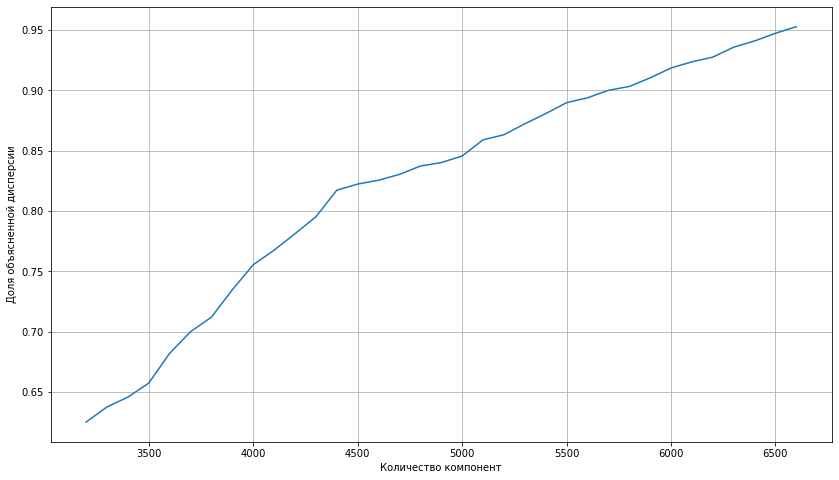

In [68]:
plt.xlabel('Количество компонент')
plt.ylabel('Доля объясненной дисперсии')
plt.grid(True)
plt.rcParams["figure.figsize"] = (14, 8)
plt.plot(graph_n_comp, graph_cumsum)

In [55]:
gm_res = []
graph_silhouette = []
graph_n_clusters = np.arange(10, 410, 10)

In [ ]:
for n_components in range(10, 410, 10):
    start = time.time()
    gm = GaussianMixture(n_components=n_components)
    gm.fit(truncated_X_txts)
    predictions = gm.predict(truncated_X_txts)
    end = time.time()
    exec_time(start,end)
    silh_score = silhouette_score(truncated_X_txts, predictions)
    print(n_components, )
    gm_res.append([predictions, gm.means_])
    graph_silhouette.append(silh_score)

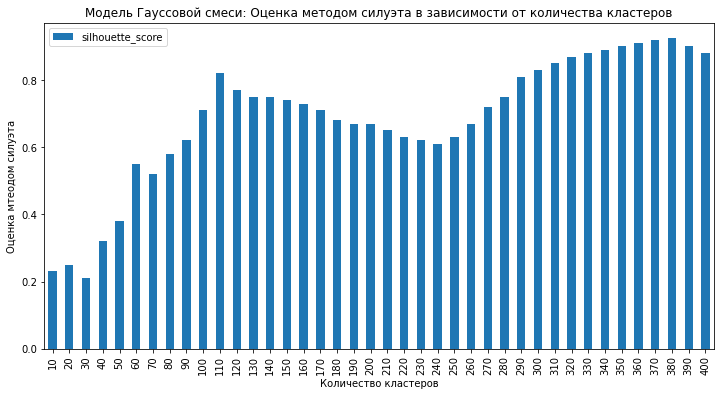

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), sharey=False)

ax = pd.DataFrame(
{
'n_clusters': graph_n_clusters,
'silhouette_score': graph_silhouette,
}
).set_index('n_clusters').plot(
title='Модель Гауссовой смеси: Оценка методом силуэта в зависимости от количества кластеров',
kind='bar',
ax=ax
)
plt.xlabel('Количество кластеров')
plt.ylabel('Оценка мтеодом силуэта')
plt.show()

In [ ]:
data, labels = sklearn.datasets.make_blobs(n_samples=500, random_state=123)

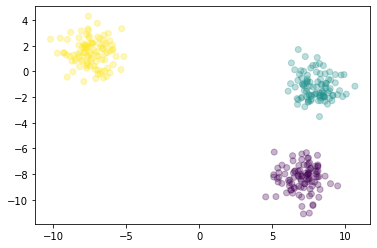

In [163]:
plt.scatter(data[:,0], data[:,1], c=labels, alpha=0.3)

In [164]:
scikit_gm = GaussianMixture(n_components=3)
scikit_gm.fit(data)
scikit_predictions = scikit_gm.predict(data)

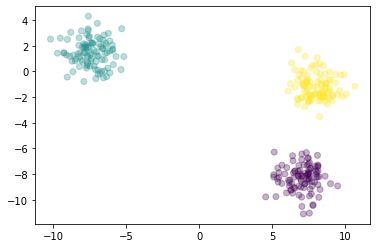

In [165]:
plt.scatter(data[:,0], data[:,1], c=scikit_predictions, alpha=0.3)

In [178]:
my_gm = GMM(n_components=3)
my_gm.fit(data)
my_predictions = my_gm.predict(data)

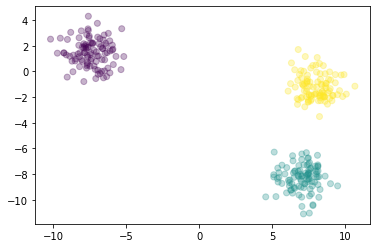

In [179]:
plt.scatter(data[:,0], data[:,1], c=my_predictions, alpha=0.3)

In [180]:
v_measure_score(labels, scikit_predictions)

1.0

In [181]:
v_measure_score(labels, my_predictions)

1.0

In [206]:
for n_samples in [150, 250, 300]:
    data, labels = sklearn.datasets.make_blobs(n_samples=n_samples)
    scikit_gm = GaussianMixture(n_components=3, init_params='random', random_state=123)
    scikit_gm.fit(data)
    scikit_predictions = scikit_gm.predict(data)
    my_gm = GMM(n_components=3)
    my_gm.fit(data)
    my_predictions = my_gm.predict(data)
    display(v_measure_score(labels, scikit_predictions))
    display(v_measure_score(labels, my_predictions))

1.0

0.6651183782779964

0.44660351278940524

0.7579132858122191

1.0

1.0

In [141]:
def gaussian(X, mu, cov):
    n = X.shape[1]
    #n = len(X)
    diff = (X - mu).T
    #print(1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5) * np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff)))
    #print(np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff)))
    #print(len(1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5) * np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff))))
    return np.diagonal(1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5) * np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff))).reshape(-1, 1)

In [142]:
from sklearn.cluster import KMeans
def initialize_clusters(X, n_clusters):
    clusters = []
    idx = np.arange(X.shape[0])
    
    kmeans = KMeans(n_clusters).fit(X)
    mu_k = kmeans.cluster_centers_
    
    for i in range(n_clusters):
        clusters.append({
            'pi_k': 1.0 / n_clusters,
            'mu_k': mu_k[i],
            'cov_k': np.identity(X.shape[1], dtype=np.float64)
        })

    return clusters

In [143]:
def expectation_step(X, clusters):
    global gamma_nk, totals
    N = X.shape[0]
    K = len(clusters)
    totals = np.zeros((N, 1), dtype=np.float64)
    gamma_nk = np.zeros((N, K), dtype=np.float64)
    
    for k, cluster in enumerate(clusters):
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']
        print(gaussian(X[0], mu_k, cov_k))
        gamma_nk[:, k] = (pi_k * gaussian(X, mu_k, cov_k)).ravel()
    
    totals = np.sum(gamma_nk, 1)
    gamma_nk /= np.expand_dims(totals, 1)

In [144]:
def maximization_step(X, clusters):
    global gamma_nk
    N = float(X.shape[0])
  
    for k, cluster in enumerate(clusters):
        gamma_k = np.expand_dims(gamma_nk[:, k], 1)
        N_k = np.sum(gamma_k, axis=0)
        
        pi_k = N_k / N
        mu_k = np.sum(gamma_k * X, axis=0) / N_k
        
        cov_k = (gamma_k * (X - mu_k)).T @ (X - mu_k) / N_k
        
        cluster['pi_k'] = pi_k
        cluster['mu_k'] = mu_k
        cluster['cov_k'] = cov_k

In [145]:
def get_likelihood(X, clusters):
    global gamma_nk, totals
    sample_likelihoods = np.log(totals)
    return np.sum(sample_likelihoods), sample_likelihoods

In [146]:
def train_gmm(X, n_clusters, n_epochs):
    clusters = initialize_clusters(X, n_clusters)
    likelihoods = np.zeros((n_epochs, ))
    scores = np.zeros((X.shape[0], n_clusters))
    history = []

    for i in range(n_epochs):
        clusters_snapshot = []
        
        # This is just for our later use in the graphs
        for cluster in clusters:
            clusters_snapshot.append({
                'mu_k': cluster['mu_k'].copy(),
                'cov_k': cluster['cov_k'].copy()
            })
            
        history.append(clusters_snapshot)
      
        expectation_step(X, clusters)
        maximization_step(X, clusters)

        likelihood, sample_likelihoods = get_likelihood(X, clusters)
        likelihoods[i] = likelihood

        print('Epoch: ', i + 1, 'Likelihood: ', likelihood)

    scores = np.log(gamma_nk)
    
    return clusters, likelihoods, scores, sample_likelihoods, history

In [147]:
n_clusters = 3
n_epochs = 50

clusters, likelihoods, scores, sample_likelihoods, history = train_gmm(data, n_clusters, n_epochs)

9.878659597619035e-27


ValueError: diag requires an array of at least two dimensions

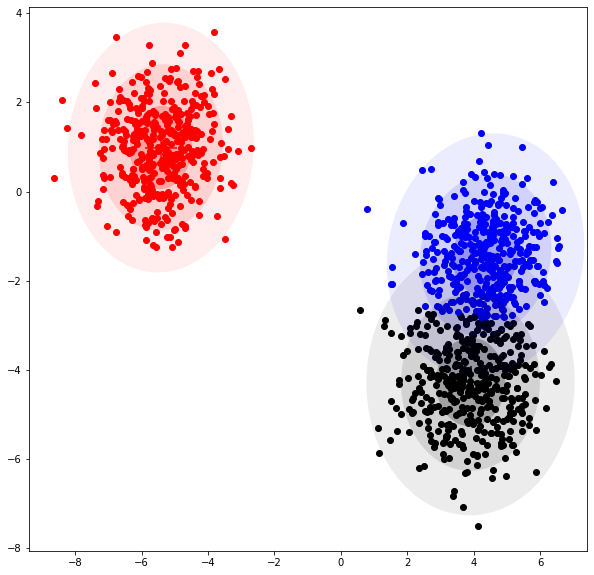

In [15]:
import imageio
import matplotlib.animation as ani
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from PIL import Image

def create_cluster_animation(X, history, scores):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    colorset = ['blue', 'red', 'black']
    images = []
    
    for j, clusters in enumerate(history):
      
        idx = 0
      
        if j % 3 != 0:
            continue
        
        plt.cla()
        
        for cluster in clusters:
            mu = cluster['mu_k']
            cov = cluster['cov_k']

            eigenvalues, eigenvectors = np.linalg.eigh(cov)
            order = eigenvalues.argsort()[::-1]
            eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
            vx, vy = eigenvectors[:,0][0], eigenvectors[:,0][1]
            theta = np.arctan2(vy, vx)

            color = colors.to_rgba(colorset[idx])

            for cov_factor in range(1, 4):
                ell = Ellipse(xy=mu, width=np.sqrt(eigenvalues[0]) * cov_factor * 2, height=np.sqrt(eigenvalues[1]) * cov_factor * 2, angle=np.degrees(theta), linewidth=2)
                ell.set_facecolor((color[0], color[1], color[2], 1.0 / (cov_factor * 4.5)))
                ax.add_artist(ell)

            ax.scatter(cluster['mu_k'][0], cluster['mu_k'][1], c=colorset[idx], s=1000, marker='+')
            idx += 1

        for i in range(X.shape[0]):
            ax.scatter(X[i, 0], X[i, 1], c=colorset[np.argmax(scores[i])], marker='o')
        
        fig.canvas.draw()
        
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        images.append(image)
    
    kwargs_write = {'fps':1.0, 'quantizer':'nq'}
    imageio.mimsave('./gmm.gif', images, fps=1)
    plt.show(Image.open('gmm.gif').convert('RGB'))
    
    
create_cluster_animation(data, history, scores)

# End of testing

# File save

In [223]:
cluster_num = 380
json_df = clear_df.copy()
json_df['cluster_id'] = 0
for i in range(cluster_num):
    indices = [j for j, x in enumerate(predictions) if x == i]
    json_df.loc[indices, 'cluster_id'] = i
json_df.to_json('my_clusters_final.json', orient='records')

In [224]:
with open('cluster_centers.json', "w") as f:
    json.dump(means.tolist(), f)

In [ ]:
# Dump the file
pickle.dump(vect, open("tfidf.pkl", "wb"))
pickle.dump(truncatedSVD, open("SVD.pkl", "wb"))
pickle.dump(gm, open("GMM.pkl", "wb"))